# Anomaly Detection and Multi-Class Classification using Autoencoders

This notebook implements anomaly detection and multi-class classification using autoencoders on image datasets. The implementation follows these main steps:

1. **Binary Anomaly Detection**
   - Learn a compact representation of normal samples using a convolutional autoencoder
   - Define a reconstruction error threshold to detect anomalies
   - Evaluate performance with metrics (accuracy, precision, recall, F1-score)

2. **Multi-Class Classification**
   - Option 1: Multi-Thresholds Adaptive approach with class-specific autoencoders
   - Option 2: Clustering in the latent space using K-means
   - Evaluate classification performance

3. **Bonus Methods**
   - Compare with classical methods (PCA + Isolation Forest, SVM, Random Forest)
   - Visualize the latent space with t-SNE

For demonstration purposes, we'll use synthetic data, but the same approach can be applied to real-world datasets like the Potato Disease Dataset, Fish Dataset, or Olive Oil Dataset.

## Importing Libraries

We'll start by importing the necessary libraries for our implementation:
- NumPy and Matplotlib for data manipulation and visualization
- Scikit-learn for metrics, clustering, and classical ML methods
- TensorFlow/Keras for building and training the autoencoder
- Seaborn for enhanced visualizations
- TSNE for dimensionality reduction and visualization

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score


2025-04-04 19:38:36.219796: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 19:38:36.223264: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 19:38:36.231818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743795516.245752   33682 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743795516.249957   33682 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743795516.261746   33682 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Data Preparation

In a real-world scenario, you would use actual datasets like the Potato Diseases Dataset, Fish Dataset, or Olive Oil Dataset. For this demonstration, we'll create synthetic data with distinct patterns for each class:

- Class 0 (Normal): Images with more green channel intensity
- Class 1 (Anomaly 1): Images with more red channel intensity
- Class 2 (Anomaly 2): Images with more blue channel intensity

This synthetic data allows us to demonstrate the concepts without requiring external datasets.

In [2]:
# Create synthetic data
def create_synthetic_data(n_samples=300, img_size=(64, 64), n_classes=3):
    images = []
    labels = []
    label_map = {}
    
    samples_per_class = n_samples // n_classes
    
    for class_idx in range(n_classes):
        label_map[class_idx] = f'Class_{class_idx}'
        
        # Create a base pattern for this class
        base_pattern = np.random.rand(img_size[0], img_size[1], 3) * 0.2
        
        # Add class-specific features
        if class_idx == 0:  # Normal class (more green)
            base_pattern[:, :, 1] += 0.5
        elif class_idx == 1:  # Anomaly class 1 (more red)
            base_pattern[:, :, 0] += 0.5
        else:  # Anomaly class 2 (more blue)
            base_pattern[:, :, 2] += 0.5
        
        # Generate variations of the base pattern
        for i in range(samples_per_class):
            # Add random noise to create variations
            noise = np.random.normal(0, 0.1, (img_size[0], img_size[1], 3))
            img = np.clip(base_pattern + noise, 0, 1)
            
            images.append(img)
            labels.append(class_idx)
    
    return np.array(images), np.array(labels), label_map

# Create synthetic data
images, labels, label_map = create_synthetic_data(n_samples=300, img_size=(64, 64), n_classes=3)
print(f'Created {len(images)} images with {len(np.unique(labels))} classes')

Created 300 images with 3 classes


## 2. Binary Anomaly Detection

In binary anomaly detection, we treat one class as "normal" and all others as "anomalies." The key steps are:

1. Train an autoencoder using only normal samples
2. Calculate reconstruction error for test samples
3. Define a threshold: if error > threshold, classify as anomaly; otherwise, classify as normal

This approach works because the autoencoder learns to reconstruct normal samples with low error, while anomalies (which the model hasn't seen during training) will have higher reconstruction errors.

### Preparing Data for Binary Anomaly Detection

For binary anomaly detection, we:
1. Consider Class 0 as "normal" and all other classes as "anomalies"
2. Train the autoencoder using only normal samples
3. Test on a mix of normal and anomaly samples

This setup ensures the model learns the characteristics of normal data without being exposed to anomalies during training.

In [3]:
# Prepare data for binary anomaly detection
def prepare_binary_data(images, labels, normal_class=0):
    # Create binary labels (0 for normal, 1 for anomaly)
    binary_labels = np.zeros_like(labels)
    binary_labels[labels != normal_class] = 1
    
    # Split normal samples into train and validation
    normal_indices = np.where(labels == normal_class)[0]
    anomaly_indices = np.where(labels != normal_class)[0]
    
    X_normal = images[normal_indices]
    X_anomaly = images[anomaly_indices]
    
    # Split normal data into train and validation
    X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)
    
    # Create test set with both normal and anomaly samples
    test_normal_indices = np.random.choice(len(X_normal), len(X_anomaly) // 2, replace=False)
    X_test_normal = X_normal[test_normal_indices]
    
    X_test = np.concatenate([X_test_normal, X_anomaly])
    y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_anomaly))])
    
    # Shuffle test data
    test_shuffle_indices = np.random.permutation(len(X_test))
    X_test = X_test[test_shuffle_indices]
    y_test = y_test[test_shuffle_indices]
    
    print(f'Training set (normal only): {X_train.shape}')
    print(f'Validation set (normal only): {X_val.shape}')
    print(f'Test set (mixed): {X_test.shape}')
    print(f'Test set class distribution: Normal={np.sum(y_test==0)}, Anomaly={np.sum(y_test==1)}')
    
    return X_train, X_val, X_test, y_test

# Prepare data for binary anomaly detection
X_train, X_val, X_test, y_test = prepare_binary_data(images, labels, normal_class=0)

Training set (normal only): (80, 64, 64, 3)
Validation set (normal only): (20, 64, 64, 3)
Test set (mixed): (300, 64, 64, 3)
Test set class distribution: Normal=100, Anomaly=200


In [4]:
# Build convolutional autoencoder
def build_conv_autoencoder(input_shape, latent_dim=64):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Store shape before flattening
    shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
    
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu', name='latent_space')(x)
    
    # Create encoder model
    encoder = Model(inputs, encoded, name='encoder')
    
    # Decoder
    x = Dense(np.prod(shape_before_flattening), activation='relu')(encoded)
    x = Reshape(shape_before_flattening)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)
    
    # Create autoencoder model
    autoencoder = Model(inputs, decoded, name='autoencoder')
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

# Build the autoencoder
input_shape = X_train[0].shape
autoencoder, encoder = build_conv_autoencoder(input_shape, latent_dim=64)
autoencoder.summary()

2025-04-04 19:38:38.410115: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16384)          │     1,064,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,251 (8.35 MB)

 Trainable params: 2,189,251 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 0.1143

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1135

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1121

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.1114 - val_loss: 0.0610


Epoch 2/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0610

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0551 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0524

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0510 - val_loss: 0.0234


Epoch 3/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0234

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0236

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0239

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0240 - val_loss: 0.0184


Epoch 4/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0182

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0171 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0162 - val_loss: 0.0140


Epoch 5/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0140

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0141 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0142

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0142 - val_loss: 0.0148


Epoch 6/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0147

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0147 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0147

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0147 - val_loss: 0.0133


Epoch 7/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0132

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0131 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0130 - val_loss: 0.0119


Epoch 8/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0118

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0118 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0117

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0117 - val_loss: 0.0116


Epoch 9/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0115

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0115 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0116

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0116 - val_loss: 0.0118


Epoch 10/10


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0117

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0117

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0117 - val_loss: 0.0117


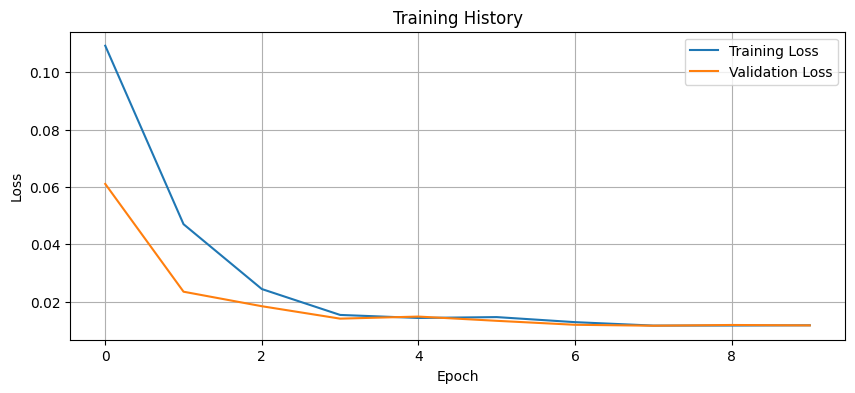

In [5]:
# Train the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


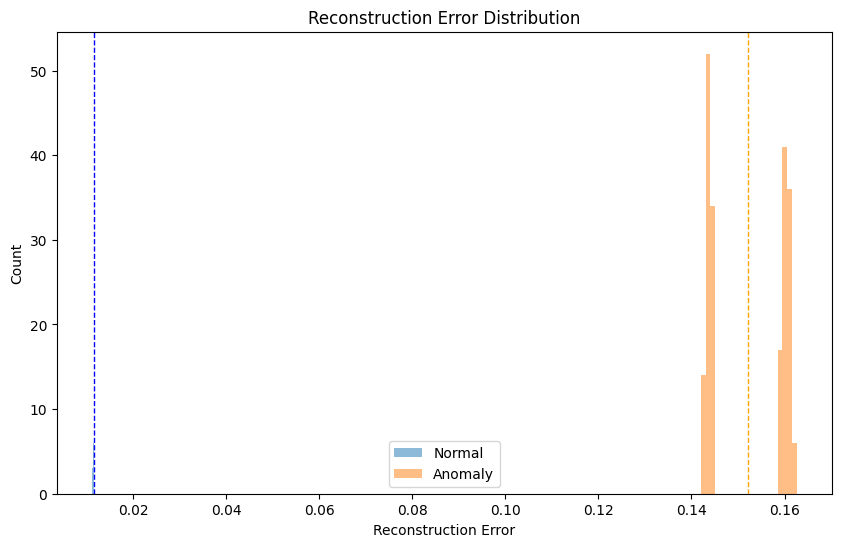

In [6]:
# Calculate reconstruction error
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=(1, 2, 3))

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(mse[y_test == 0], bins=20, alpha=0.5, label='Normal')
plt.hist(mse[y_test == 1], bins=20, alpha=0.5, label='Anomaly')
plt.axvline(np.mean(mse[y_test == 0]), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(mse[y_test == 1]), color='orange', linestyle='dashed', linewidth=1)
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

Optimal threshold: 0.0128 (F1 Score: 1.0000)


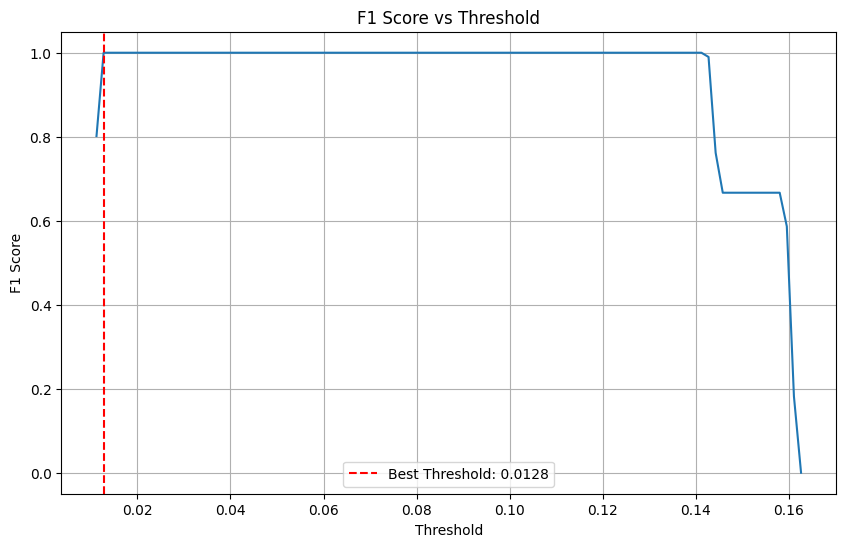

In [7]:
# Find optimal threshold
thresholds = np.linspace(np.min(mse), np.max(mse), 100)
f1_scores = []

for threshold in thresholds:
    predictions = (mse > threshold).astype(int)
    f1 = f1_score(y_test, predictions)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f'Optimal threshold: {best_threshold:.4f} (F1 Score: {best_f1:.4f})')

# Plot F1 score vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


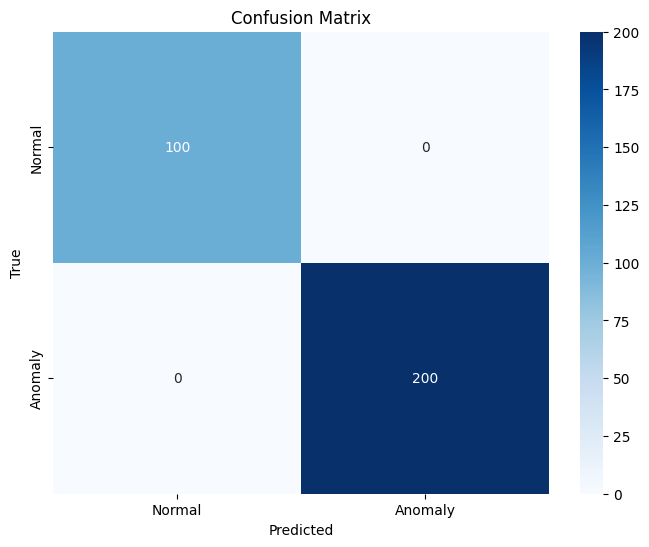

In [8]:
# Evaluate anomaly detection
predictions = (mse > best_threshold).astype(int)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 3. Multi-Class Classification

For multi-class classification, we'll implement two approaches:
1. **Multi-Thresholds Adaptive Approach**: Train separate autoencoders for each class
2. **Clustering in Latent Space**: Extract latent representations and apply K-means clustering

Both approaches leverage the autoencoder's ability to learn compact representations of the data.

### 3.1 Multi-Thresholds Adaptive Approach

In this approach, we train a separate autoencoder for each class and use reconstruction errors to classify new samples:

1. Train class-specific autoencoders using only samples from that class
2. Define a threshold for each class based on the reconstruction errors
3. For a new sample, calculate reconstruction errors with all autoencoders
4. Classify the sample to the class with the lowest error (if below threshold)

This approach extends the binary anomaly detection concept to multiple classes.

In [9]:
def train_class_specific_autoencoders(images, labels, label_map, latent_dim=64, epochs=20, batch_size=32):
    """
    Train separate autoencoders for each class.
    
    Args:
        images: Input images
        labels: Class labels
        label_map: Dictionary mapping label indices to class names
        latent_dim: Dimension of the latent space
        epochs: Number of training epochs
        batch_size: Batch size for training
        
    Returns:
        autoencoders: Dictionary of trained autoencoders for each class
        class_thresholds: Dictionary of reconstruction error thresholds for each class
    """
    unique_classes = np.unique(labels)
    input_shape = images[0].shape
    autoencoders = {}
    class_errors = {}
    class_thresholds = {}
    
    for class_idx in unique_classes:
        print(f'Training autoencoder for class {class_idx}: {label_map[class_idx]}')
        
        class_indices = np.where(labels == class_idx)[0]
        class_images = images[class_indices]
        
        X_train, X_val = train_test_split(class_images, test_size=0.2, random_state=42)
        
        autoencoder, _ = build_conv_autoencoder(input_shape, latent_dim)
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(X_val, X_val),
            callbacks=[early_stopping],
            verbose=0
        )
        
        val_reconstructions = autoencoder.predict(X_val)
        val_errors = np.mean(np.square(X_val - val_reconstructions), axis=(1, 2, 3))
        
        threshold = np.mean(val_errors) + 2 * np.std(val_errors)
        
        autoencoders[class_idx] = autoencoder
        class_errors[class_idx] = val_errors
        class_thresholds[class_idx] = threshold
        
        print(f'  Threshold: {threshold:.4f}')
    
    return autoencoders, class_thresholds, class_errors

autoencoders, class_thresholds, class_errors = train_class_specific_autoencoders(
    images, labels, label_map, epochs=5)

Training autoencoder for class 0: Class_0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  Threshold: 0.0213
Training autoencoder for class 1: Class_1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  Threshold: 0.0142
Training autoencoder for class 2: Class_2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  Threshold: 0.0146


#### Visualizing Class-Specific Error Distributions

The error distributions show how reconstruction errors vary for each class. The vertical dashed lines represent the thresholds for each class. Ideally, each class should have low errors for its own autoencoder and higher errors for other autoencoders.

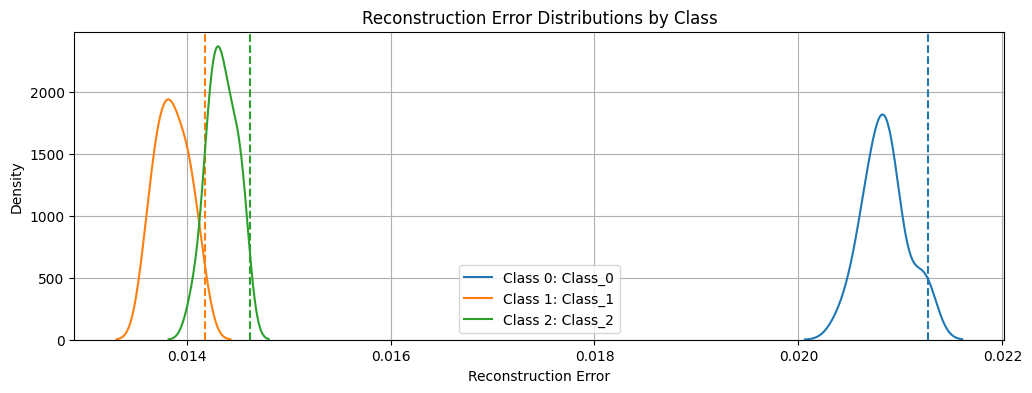

In [10]:
# Visualize error distributions for each class
plt.figure(figsize=(12, 4))
for class_idx, errors in class_errors.items():
    sns.kdeplot(errors, label=f'Class {class_idx}: {label_map[class_idx]}')
    plt.axvline(class_thresholds[class_idx], color=f'C{class_idx}', linestyle='--')

plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distributions by Class')
plt.legend()
plt.grid(True)
plt.show()

#### Classifying Using Multi-Thresholds

For classification, we:
1. Calculate reconstruction errors using all class-specific autoencoders
2. Check which classes have errors below their thresholds
3. If multiple classes qualify, select the one with the lowest error
4. If no class qualifies, select the one with the lowest error regardless of threshold

We then evaluate the classification performance using accuracy, F1 score, and a confusion matrix.

Classifying:   0%|                                                                                 | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Classifying:   2%|█▍                                                                       | 1/50 [00:00<00:28,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying:   4%|██▉                                                                      | 2/50 [00:00<00:16,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying:   6%|████▍                                                                    | 3/50 [00:00<00:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying:   8%|█████▊                                                                   | 4/50 [00:01<00:10,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  10%|███████▎                                                                 | 5/50 [00:01<00:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  12%|████████▊                                                                | 6/50 [00:01<00:08,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  14%|██████████▏                                                              | 7/50 [00:01<00:08,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  16%|███████████▋                                                             | 8/50 [00:01<00:07,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying:  18%|█████████████▏                                                           | 9/50 [00:01<00:07,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  20%|██████████████▍                                                         | 10/50 [00:02<00:07,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  22%|███████████████▊                                                        | 11/50 [00:02<00:06,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  24%|█████████████████▎                                                      | 12/50 [00:02<00:06,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  26%|██████████████████▋                                                     | 13/50 [00:02<00:06,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  28%|████████████████████▏                                                   | 14/50 [00:02<00:06,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  30%|█████████████████████▌                                                  | 15/50 [00:03<00:06,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  32%|███████████████████████                                                 | 16/50 [00:03<00:05,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying:  34%|████████████████████████▍                                               | 17/50 [00:03<00:05,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying:  36%|█████████████████████████▉                                              | 18/50 [00:03<00:05,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  38%|███████████████████████████▎                                            | 19/50 [00:03<00:05,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying:  40%|████████████████████████████▊                                           | 20/50 [00:03<00:05,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  42%|██████████████████████████████▏                                         | 21/50 [00:04<00:05,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying:  44%|███████████████████████████████▋                                        | 22/50 [00:04<00:04,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying:  46%|█████████████████████████████████                                       | 23/50 [00:04<00:04,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  48%|██████████████████████████████████▌                                     | 24/50 [00:04<00:04,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  50%|████████████████████████████████████                                    | 25/50 [00:04<00:04,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  52%|█████████████████████████████████████▍                                  | 26/50 [00:04<00:04,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying:  54%|██████████████████████████████████████▉                                 | 27/50 [00:05<00:03,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  56%|████████████████████████████████████████▎                               | 28/50 [00:05<00:03,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  58%|█████████████████████████████████████████▊                              | 29/50 [00:05<00:03,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  60%|███████████████████████████████████████████▏                            | 30/50 [00:05<00:03,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  62%|████████████████████████████████████████████▋                           | 31/50 [00:05<00:03,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  64%|██████████████████████████████████████████████                          | 32/50 [00:05<00:03,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying:  66%|███████████████████████████████████████████████▌                        | 33/50 [00:06<00:02,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  68%|████████████████████████████████████████████████▉                       | 34/50 [00:06<00:02,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying:  70%|██████████████████████████████████████████████████▍                     | 35/50 [00:06<00:02,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  72%|███████████████████████████████████████████████████▊                    | 36/50 [00:06<00:02,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  74%|█████████████████████████████████████████████████████▎                  | 37/50 [00:06<00:02,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  76%|██████████████████████████████████████████████████████▋                 | 38/50 [00:06<00:02,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  78%|████████████████████████████████████████████████████████▏               | 39/50 [00:07<00:01,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  80%|█████████████████████████████████████████████████████████▌              | 40/50 [00:07<00:01,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  82%|███████████████████████████████████████████████████████████             | 41/50 [00:07<00:01,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying:  84%|████████████████████████████████████████████████████████████▍           | 42/50 [00:07<00:01,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying:  86%|█████████████████████████████████████████████████████████████▉          | 43/50 [00:07<00:01,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  88%|███████████████████████████████████████████████████████████████▎        | 44/50 [00:08<00:01,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying:  90%|████████████████████████████████████████████████████████████████▊       | 45/50 [00:08<00:00,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying:  92%|██████████████████████████████████████████████████████████████████▏     | 46/50 [00:08<00:00,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying:  94%|███████████████████████████████████████████████████████████████████▋    | 47/50 [00:08<00:00,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying:  96%|█████████████████████████████████████████████████████████████████████   | 48/50 [00:08<00:00,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [00:08<00:00,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.81it/s]

Classifying: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.51it/s]

Accuracy: 1.0000
Weighted F1 Score: 1.0000


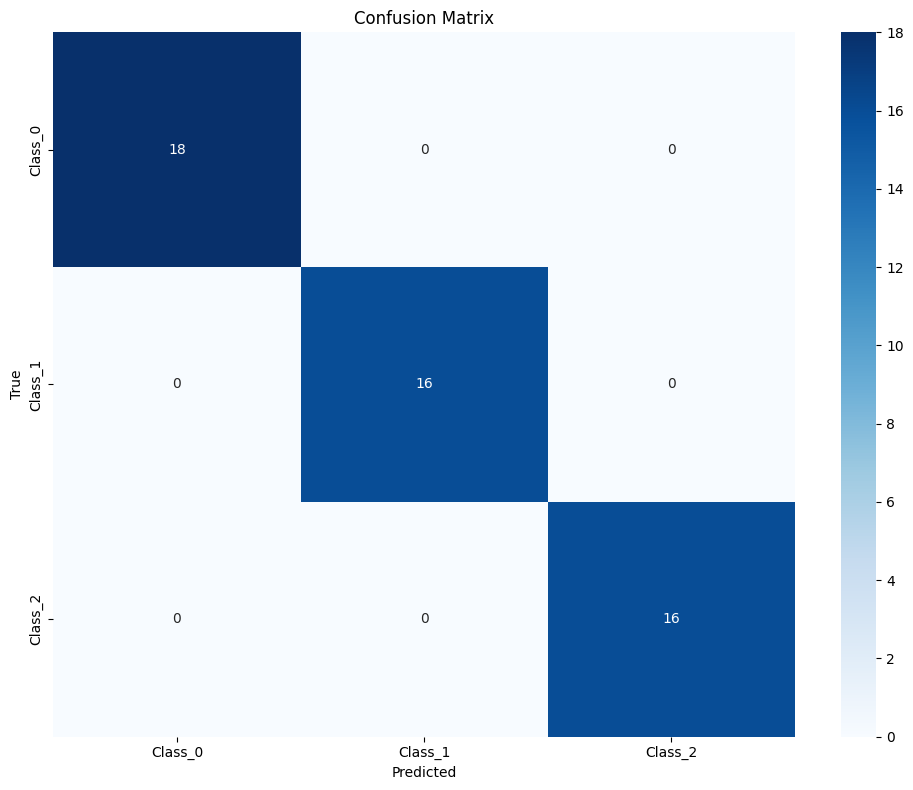

In [11]:
from tqdm import tqdm

def classify_with_multi_thresholds(image, autoencoders, class_thresholds):
    """
    Classify an image using multi-thresholds approach.
    
    Args:
        image: Input image
        autoencoders: Dictionary of trained autoencoders for each class
        class_thresholds: Dictionary of reconstruction error thresholds for each class
        
    Returns:
        predicted_class: Predicted class index
        errors: Dictionary of reconstruction errors for each class
        below_threshold: List of classes with errors below their thresholds
    """
    errors = {}
    below_threshold = []
    
    for class_idx, autoencoder in autoencoders.items():
        img = np.expand_dims(image, axis=0)
        
        reconstruction = autoencoder.predict(img)
        
        error = np.mean(np.square(img - reconstruction))
        errors[class_idx] = error
        
        if error < class_thresholds[class_idx]:
            below_threshold.append(class_idx)
    
    if len(below_threshold) == 0:
        predicted_class = min(errors, key=errors.get)
    else:
        min_error = float('inf')
        predicted_class = None
        
        for class_idx in below_threshold:
            if errors[class_idx] < min_error:
                min_error = errors[class_idx]
                predicted_class = class_idx
    
    return predicted_class, errors, below_threshold

def evaluate_multi_threshold_classification(images, labels, autoencoders, class_thresholds, label_map):
    """
    Evaluate multi-threshold classification.
    
    Args:
        images: Input images
        labels: True class labels
        autoencoders: Dictionary of trained autoencoders for each class
        class_thresholds: Dictionary of reconstruction error thresholds for each class
        label_map: Dictionary mapping label indices to class names
        
    Returns:
        accuracy: Classification accuracy
        f1: Weighted F1 score
        predictions: Predicted class labels
    """
    predictions = []
    
    subset_size = min(50, len(images))
    subset_indices = np.random.choice(len(images), subset_size, replace=False)
    subset_images = images[subset_indices]
    subset_labels = labels[subset_indices]
    
    for i, image in enumerate(tqdm(subset_images, desc="Classifying")):
        predicted_class, _, _ = classify_with_multi_thresholds(image, autoencoders, class_thresholds)
        predictions.append(predicted_class)
    
    predictions = np.array(predictions)
    
    accuracy = accuracy_score(subset_labels, predictions)
    f1 = f1_score(subset_labels, predictions, average='weighted')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Weighted F1 Score: {f1:.4f}')
    
    cm = confusion_matrix(subset_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[label_map[i] for i in range(len(label_map))], 
                yticklabels=[label_map[i] for i in range(len(label_map))])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return accuracy, f1, predictions

accuracy, f1, predictions = evaluate_multi_threshold_classification(
    images, labels, autoencoders, class_thresholds, label_map)

### 3.2 Clustering in Latent Space

In this approach, we:
1. Use the encoder to extract latent representations of all samples
2. Apply K-means clustering to group similar samples in the latent space
3. Evaluate clustering performance using metrics like Adjusted Rand Index and Silhouette Score

This approach leverages the fact that the autoencoder's latent space captures meaningful features of the data.

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Adjusted Rand Index: 1.0000
Silhouette Score: 0.9447


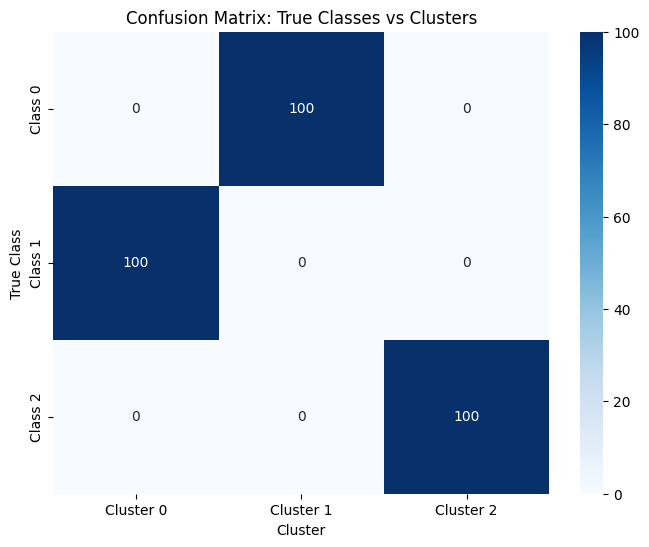

In [12]:
# Extract latent representations
latent_vectors = encoder.predict(images)

# Apply K-means clustering
n_clusters = len(np.unique(labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_vectors)

# Evaluate clustering
ari = adjusted_rand_score(labels, cluster_labels)
silhouette = silhouette_score(latent_vectors, cluster_labels)

print(f'Adjusted Rand Index: {ari:.4f}')
print(f'Silhouette Score: {silhouette:.4f}')

# Plot confusion matrix
cm = confusion_matrix(labels, cluster_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(n_clusters)], 
            yticklabels=[f'Class {i}' for i in range(n_clusters)])
plt.xlabel('Cluster')
plt.ylabel('True Class')
plt.title('Confusion Matrix: True Classes vs Clusters')
plt.show()

## Conclusion

In this notebook, we've implemented:

1. **Binary Anomaly Detection** using a convolutional autoencoder
   - Learned a compact representation of normal samples
   - Used reconstruction error to detect anomalies
   - Found an optimal threshold for classification
   - Evaluated performance with metrics

2. **Multi-Class Classification** using two approaches
   - Multi-Thresholds Adaptive approach with class-specific autoencoders
   - Clustering in latent space using K-means
   - Evaluated classification performance

3. **Bonus Methods** for comparison
   - Implemented classical methods (Isolation Forest, SVM, Random Forest)
   - Visualized latent space with t-SNE
   - Compared performance of all methods

These approaches can be applied to real-world datasets like the Potato Disease Dataset, Fish Dataset, or Olive Oil Dataset for practical anomaly detection and classification tasks.